# Set up
Import libraries

In [15]:
import pandas as pd
import numpy as np
import json
import pickle
import os
import shutil #save images
from tqdm import tqdm #progress bar
import cv2
import matplotlib.pyplot as plt
import joblib


# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

# Authenticate.
from google.colab import auth
auth.authenticate_user()

# Install Cloud Storage FUSE.
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  1022  100  1022    0     0   6572      0 --:--:-- --:--:-- --:--:--  6593
OK
48 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' d

##Mount google drive and GCS

In [3]:
# Mount a Cloud Storage bucket or location
mount_path = "281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518"
local_path = f"/mnt/gs/{mount_path}"

!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

{"timestamp":{"seconds":1722784271,"nanos":207938748},"severity":"INFO","message":"Start gcsfuse/2.4.0 (Go version go1.22.4) for app \"\" using mount point: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518\n"}
{"timestamp":{"seconds":1722784271,"nanos":208202253},"severity":"INFO","message":"GCSFuse mount command flags: {\"AppName\":\"\",\"Foreground\":false,\"ConfigFile\":\"\",\"MountOptions\":{},\"DirMode\":493,\"FileMode\":420,\"Uid\":-1,\"Gid\":-1,\"ImplicitDirs\":true,\"OnlyDir\":\"\",\"RenameDirLimit\":0,\"IgnoreInterrupts\":true,\"CustomEndpoint\":null,\"BillingProject\":\"\",\"KeyFile\":\"\",\"TokenUrl\":\"\",\"ReuseTokenFromUrl\":true,\"EgressBandwidthLimitBytesPerSecond\":-1,\"OpRateLimitHz\":-1,\"SequentialReadSizeMb\":200,\"AnonymousAccess\":false,\"MaxRetrySleep\":30000000000,\"MaxRetryAttempts\":0,\"StatCacheCapacity\":20460,\"StatCacheTTL\":60000000000,\"TypeCacheTTL\":60000000000,\"KernelListCacheTtlSeconds\":0,\"HttpClientTimeout\":0,\"RetryMultiplier\":2,\"Tem

In [4]:
input_path = os.path.join(local_path, 'feature_matrices')

#test mounting
os.listdir(input_path)

['test_features_matrix.pkl',
 'test_label.pkl',
 'train_features_matrix.pkl',
 'train_label.pkl',
 'val_features_matrix.pkl',
 'validation_label.pkl']

## Load Train and Validation Features

In [5]:
def load_image_labels(input_path):
    train_lb = pickle.load(open(input_path + '/' + 'train_label'  + '.pkl', 'rb'))
    val_lb = pickle.load(open(input_path + '/' + 'validation_label' + '.pkl', 'rb'))
    test_lb = pickle.load(open(input_path + '/' + 'test_label' + '.pkl', 'rb'))

    return train_lb, val_lb, test_lb

In [6]:
#load the labels from file in drive
df_train_label = load_image_labels(input_path)[0]
df_val_label = load_image_labels(input_path)[1]
df_test_label = load_image_labels(input_path)[2]


## Load Train and Validation Features

In [7]:
def load_feature_matrices(input_path):
    train_fm = pickle.load(open(input_path + '/' + 'train_features_matrix'  + '.pkl', 'rb'))
    val_fm = pickle.load(open(input_path + '/' + 'val_features_matrix' + '.pkl', 'rb'))
    test_fm = pickle.load(open(input_path + '/' + 'test_features_matrix' + '.pkl', 'rb'))

    return train_fm, val_fm, test_fm

In [8]:
# loading feature matrics for each set
x_train = load_feature_matrices(input_path)[0]
x_val = load_feature_matrices(input_path)[1]
x_test = load_feature_matrices(input_path)[2]

In [9]:
# get indices for feature matrices
train_fm_ind = pickle.load(open(local_path + '/features' + '/train_sift_std'  + '.pkl', 'rb'))
val_fm_ind = pickle.load(open(local_path + '/features' + '/validation_sift_std' + '.pkl', 'rb'))
test_fm_ind = pickle.load(open(local_path + '/features' + '/test_sift_std' + '.pkl', 'rb'))

In [10]:
# create dataframe with image filename as the indices
df_train = pd.DataFrame({'pca': [pca_vector for pca_vector in x_train]}, index = list(train_fm_ind.keys()))
df_val = pd.DataFrame({'pca': [pca_vector for pca_vector in x_val]}, index = list(val_fm_ind.keys()))
df_test = pd.DataFrame({'pca': [pca_vector for pca_vector in x_test]}, index = list(test_fm_ind.keys()))

In [11]:
# join feature dataframes with labels and groups on the indices
# puting df_{set}_label on the left to preserve suffled image orders
df_train = df_train_label.join(df_train, on=None, how='left', validate='one_to_one')
df_val = df_val_label.join(df_val, on=None, how='left', validate='one_to_one')
df_test = df_test_label.join(df_test, on=None, how='left', validate='one_to_one')

## Combine train and validation feature dataframes



In [12]:
# combine train and val dataframes
df = pd.concat([df_train, df_val], axis=0)

# Gap Analysis


In [13]:
# X, y, and groups are your data and group labels
# specify feature columns
X = np.vstack(df['pca'].to_numpy())
# label coluns
y = df['label']
# read group from labels
groups =  df['group']
# specify splits
splits = 5
# path storing outputs
output_path = os.path.join(local_path, 'weights')
os.makedirs(output_path, exist_ok=True)


In [16]:
# load best-performing model from grid search
# {'covariance_estimator': None, 'n_components': None, 'priors': None, 'shrinkage': 0.4, 'solver': 'lsqr', 'store_covariance': False}
output_path = os.path.join(local_path, 'weights')
best_model = pickle.load(open(output_path + '/lda_best_model_0801.pkl', 'rb'))

# plot confusion matrix
y_pred = best_model.predict(X)
cm = confusion_matrix(y, y_pred)

In [18]:
# X, y, and groups are your data and group labels
# specify feature columns
X_test = np.vstack(df_test['pca'].to_numpy())
# label coluns
y_test = df_test['label']
# read group from labels
groups_test =  df_test['group']

In [19]:
# test set prediction and accuracy for best model
y_pred_test = best_model.predict(X_test)

## Train Set

In [20]:
# wrongly classified images
# train prediction y_pred
# train real label y
y_train = pd.DataFrame({
    'label': y,
    'pred': y_pred
})

y_train['match'] = np.where(y_train['label']==y_train['pred'], True, False)


In [21]:
# wrongly labelled images
y_false = y_train[~y_train['match']]

'Dasypus Species'

In [47]:
y_false.head(10)

,label,pred,match
image,,,
M00_103EK113_06230502.JPG,Peccary,Dasypus Species,False
M05_102EK113_06290747.JPG,Peccary,Black Agouti,False
N14_104EK113_06290043.JPG,Peccary,Black Agouti,False
N25_104EK113_07200395.JPG,Peccary,Black Agouti,False
N07_100EK113_02210665.JPG,Peccary,Dasypus Species,False
M04_102EK113_02120859.JPG,Peccary,Bos Species,False
M02_100EK113_02140817.JPG,Peccary,Dasypus Species,False
M02_100EK113_02140818.JPG,Peccary,Dasypus Species,False
M05_100EK113_04170825.JPG,Peccary,Dasypus Species,False


In [22]:
y_false['label'].value_counts()

,count
label,
Spotted Paca,69
Black Agouti,41
Peccary,39
Dasypus Species,36
South American Coati,21
Bos Species,3


In [23]:
# wrong Peccary images labelled as Black Agouti
# get image feature from each index
ind_wrong = y_false[(y_false['label']=='Peccary') & (y_false['pred']=='Black Agouti')].index

# black agouti images
ind_corr = y_train[(y_train['label']=='Black Agouti') & (y_train['pred']=='Black Agouti')].index

### Visualize All Wrongly Inferred Images

In [50]:
def visualize_class_images(class_name, num_cols, df_wrong_img, input_path, batch_size=10):
    # Filter the dataframe for the specified class
    species = df_wrong_img[df_wrong_img['label'] == class_name]
    num_images = len(species)
    total_processed = 0

    print(f"Processing class: {class_name}")

    for start_idx in range(0, num_images, batch_size):
        end_idx = min(start_idx + batch_size, num_images)
        batch_filenames = species.index[start_idx:end_idx]

        # Calculate the number of rows needed for the current batch
        num_rows = (len(batch_filenames) + num_cols - 1) // num_cols

        # Limit the figure size to avoid exceeding Matplotlib's limits
        max_fig_height = 20  # Maximum figure height in inches
        fig_height = min(num_rows * 5, max_fig_height)

        print(f'{num_rows=}, {num_cols=}')

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, fig_height))

        for j, filename in tqdm(enumerate(batch_filenames), total=len(batch_filenames), desc=f"Processing batch {start_idx//batch_size + 1}"):

            try:
              os.path.exists(f"{input_path}/{filename}")
              img = cv2.imread(f"{input_path}/{filename}")
              img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            except:
              alt_path = f'{local_path}/raw-data/validation_data'
              os.path.exists(f"{alt_path}/{filename}")
              img = cv2.imread(f"{alt_path}/{filename}")

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            pred = df_wrong_img.loc[filename]['pred']
            row = j // num_cols
            col = j % num_cols

            if num_rows > 1:
              axes[row, col].imshow(img)
              axes[row, col].axis('off')
              axes[row, col].set_title(f"Label: {class_name}\n Prediction: {pred}", fontsize=8)  # Reduce font size if needed
            else:
              axes[col].imshow(img)
              axes[col].axis('off')
              axes[col].set_title(f"Label: {class_name}\n Prediction: {pred}", fontsize=8)  # Reduce font size if needed

        # Turn off any remaining empty subplots
        for k in range(len(batch_filenames), num_rows * num_cols):
            row = k // num_cols
            col = k % num_cols
            if num_rows > 1:
              axes[row, col].axis('off')
            else:
              axes[col].axis('off')

        plt.tight_layout()
        plt.subplots_adjust(hspace=-0.3)  # Set hspace to a negative value to remove space
        plt.show()  # Display the plot

        # Close the current figure to free up memory
        plt.close(fig)

        # Update the total number of processed images
        total_processed += len(batch_filenames)

    print(f"Total images processed for class {class_name}: {total_processed}/{num_images}")

In [25]:
img_path = f'{local_path}/raw-data/train_data'

In [51]:
visualize_class_images(class_name='Peccary', num_cols=5, df_wrong_img=y_false, input_path=img_path, batch_size=10)

Output hidden; open in https://colab.research.google.com to view.

In [52]:
visualize_class_images(class_name='Spotted Paca', num_cols=5, df_wrong_img=y_false, input_path=img_path, batch_size=10)

Output hidden; open in https://colab.research.google.com to view.

In [56]:
visualize_class_images(class_name='Black Agouti', num_cols=5, df_wrong_img=y_false, input_path=img_path, batch_size=10)

Output hidden; open in https://colab.research.google.com to view.

In [53]:
visualize_class_images(class_name='Dasypus Species', num_cols=5, df_wrong_img=y_false, input_path=img_path, batch_size=10)

Output hidden; open in https://colab.research.google.com to view.

In [54]:
visualize_class_images(class_name='South American Coati', num_cols=5, df_wrong_img=y_false, input_path=img_path, batch_size=10)

Output hidden; open in https://colab.research.google.com to view.

## Bos Species
The wrongly classified Bos Species images are all blurred images or with the Bos Species in the far back.

Processing class: Bos Species
num_rows=1, num_cols=5


Processing batch 1: 100%|██████████| 3/3 [00:00<00:00, 12.66it/s]


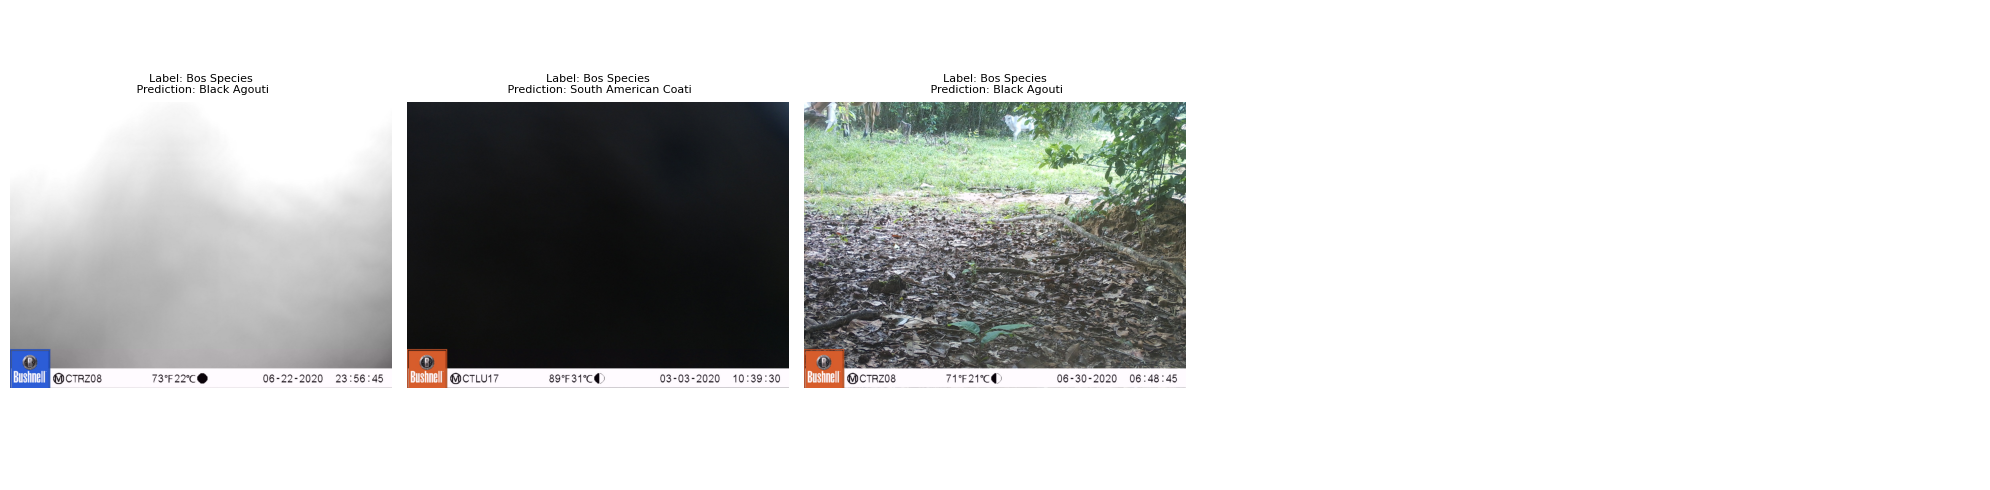

Total images processed for class Bos Species: 3/3


In [55]:
visualize_class_images(class_name='Bos Species', num_cols=5, df_wrong_img=y_false, input_path=img_path, batch_size=10)